# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **weather phenomena** (see below) for the region of **Ann Arbor, Michigan, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Ann Arbor, Michigan, United States** to Ann Arbor, USA. In that case at least one source file must be about **Ann Arbor, Michigan, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Ann Arbor, Michigan, United States** and **weather phenomena**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **weather phenomena**?  For this category you might want to consider seasonal changes, natural disasters, or historical trends.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

## 1 Region and Domain

##### State the region and the domain category that your data sets are about

    Phoenix, Arizona, United States
    Weather and Crime

## 2 Research Question

###### You must state a question about the domain category and region that you identified as being interesting.

    How does changes in temperature affect the amount of crimes committed in Phoenix, AZ (2017-2021)? Specifically, does crime increase as the temperature increases?

## 3 Links

###### You must provide at least two links to publicly accessible datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form such as Wikipedia pages.

 - https://www.phoenixopendata.com/dataset/crime-data/resource/0ce3411a-2fc6-4302-a33f-167f68608a20
 - https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/locations/CITY:US040011/detail
     - (Selected "Maximum temperature (TMAX)" and "Minimum temperature (TMIN)" from Air Temperature category)

## 4 Image

###### You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo’s principles of truthfulness, functionality, beauty, and insightfulness.

In [81]:
%matplotlib notebook

import calendar
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

In [82]:
# Read in Phoenix crime statistics
crime_df = pd.read_csv("PhoenixCrimeStats_2015-11_2022-03.csv.gz", low_memory=False)

# Clean and format data
crime_df.columns = ['Incident_Number','Occurred_On_Date','Occurred_To_Date','Uniform_Crime_Reporting_Category','Address','Zip_Code','Premise_Type']
crime_df = crime_df[crime_df['Occurred_On_Date'].notnull()]
crime_df['Occurred_On_Date'] = pd.to_datetime(crime_df['Occurred_On_Date'], format="%m/%d/%Y %H:%M").dt.normalize()
crime_df['Occurred_To_Date'] = pd.to_datetime(crime_df['Occurred_To_Date'], format="%m/%d/%Y %H:%M").dt.normalize()
crime_df['Premise_Type'] = crime_df['Premise_Type'].fillna('UNKNOWN')


# Group total crime data
crime_agg_df = crime_df.groupby(['Occurred_On_Date'])['Incident_Number'].count().reset_index().rename(columns={'Incident_Number':'Crime_Count'})
crime_agg_df['5_Day_SMA_Crime'] =  crime_agg_df['Crime_Count'].rolling(5).mean()

# Filter total crime data to 2017-2021 data excluding leap days
crime_agg_df = crime_agg_df[
                    (crime_agg_df['Occurred_On_Date'].dt.year >= 2017)
                    & (crime_agg_df['Occurred_On_Date'].dt.year <= 2021)
                    & ~((crime_agg_df['Occurred_On_Date'].dt.month == 2) & (crime_agg_df['Occurred_On_Date'].dt.day == 29))
                   ].reset_index().drop('index',axis=1)

# Group crime category data
crime_cat_agg_df = crime_df.groupby(['Occurred_On_Date','Uniform_Crime_Reporting_Category'])['Incident_Number'].count().reset_index().rename(columns={'Incident_Number':'Crime_Count'})

dates = crime_cat_agg_df['Occurred_On_Date'].unique()
crime_cats = crime_cat_agg_df['Uniform_Crime_Reporting_Category'].unique()
idx = pd.MultiIndex.from_product((dates, crime_cats), names=['Occurred_On_Date', 'Uniform_Crime_Reporting_Category'])

crime_cat_agg_df = crime_cat_agg_df.set_index(['Occurred_On_Date', 'Uniform_Crime_Reporting_Category']).reindex(idx,fill_value=0).reset_index()
crime_cat_agg_df = (crime_cat_agg_df.assign(Five_Day_SMA_Crime=crime_cat_agg_df.groupby(['Uniform_Crime_Reporting_Category'], as_index=False)['Crime_Count'].rolling(5).mean().reset_index(0, drop=True))).rename(columns={'Five_Day_SMA_Crime':'5_Day_SMA_Crime'})

# Filter crime category data to 2017-2021 data excluding leap days
crime_cat_agg_df = crime_cat_agg_df[
                    (crime_cat_agg_df['Occurred_On_Date'].dt.year >= 2017)
                    & (crime_cat_agg_df['Occurred_On_Date'].dt.year <= 2021)
                    & ~((crime_cat_agg_df['Occurred_On_Date'].dt.month == 2) & (crime_cat_agg_df['Occurred_On_Date'].dt.day == 29))
                   ].reset_index().drop('index',axis=1)

# Sample output
crime_agg_df
# crime_cat_agg_df
# crime_cat_agg_df[(crime_cat_agg_df['Uniform_Crime_Reporting_Category']=='MURDER AND NON-NEGLIGENT MANSLAUGHTER')]

Occurred_On_Date  Crime_Count  5_Day_SMA_Crime
0          2017-01-01          237            192.6
1          2017-01-02          146            185.4
2          2017-01-03          179            182.8
3          2017-01-04          180            183.4
4          2017-01-05          172            182.8
5          2017-01-06          187            172.8
6          2017-01-07          177            179.0
7          2017-01-08          168            176.8
8          2017-01-09          169            174.6
9          2017-01-10          180            176.2
10         2017-01-11          178            174.4
11         2017-01-12          196            178.2
12         2017-01-13          191            182.8
13         2017-01-14          196            188.2
14         2017-01-15          151            182.4
15         2017-01-16          196            186.0
16         2017-01-17          196            186.0
17         2017-01-18          152            178.2
18         2017-01-19          174            173.8
19         2017-01-20          177            179.0
20         2017-01-21          173            174.4
21         2017-01-22          167            168.6
22         2017-01-23          182            174.6
23         2017-01-24          190            177.8
24         2017-01-25          189            180.2
25         2017-01-26          177            181.0
26         2017-01-27          205            188.6
27         2017-01-28          175            187.2
28         2017-01-29          144            178.0
29         2017-01-30          176            175.4
...               ...          ...              ...
1795       2021-12-02          178            185.6
1796       2021-12-03          186            190.6
1797       2021-12-04          184            187.2
1798       2021-12-05          160            182.6
1799       2021-12-06          169            175.4
1800       2021-12-07          182            176.2
1801       2021-12-08          183            175.6
1802       2021-12-09          173            173.4
1803       2021-12-10          171            175.6
1804       2021-12-11          188            179.4
1805       2021-12-12          171            177.2
1806       2021-12-13          189            178.4
1807       2021-12-14          156            175.0
1808       2021-12-15          195            179.8
1809       2021-12-16          159            174.0
1810       2021-12-17          184            176.6
1811       2021-12-18          152            169.2
1812       2021-12-19          162            170.4
1813       2021-12-20          163            164.0
1814       2021-12-21          164            165.0
1815       2021-12-22          193            166.8
1816       2021-12-23          185            173.4
1817       2021-12-24          157            172.4
1818       2021-12-25          136            167.0
1819       2021-12-26          126            159.4
1820       2021-12-27          183            157.4
1821       2021-12-28          160            152.4
1822       2021-12-29          180            157.0
1823       2021-12-30          181            166.0
1824       2021-12-31          202            181.2

[1825 rows x 3 columns]

In [83]:
# Read in Phoenix weather statistics 2017-2021
weather_df = pd.read_csv('Phoenix_Tempurates_2017-01-2021-12.csv')

# Clean and format data and filter out leap day
weather_df = pd.melt(weather_df,id_vars=['STATION','NAME','DATE'],value_vars=['TMAX','TMIN'],var_name='ELEMENT',value_name='DATA_VALUE')
weather_df.columns = ['Station','Name','Date','Element','Data_Value']
weather_df = weather_df[weather_df['Data_Value'].notnull()]
weather_df['Date'] = pd.to_datetime(weather_df['Date'], format='%m/%d/%Y')

max_temps_df = weather_df[weather_df['Element'] == 'TMAX'].groupby('Date')[['Data_Value']].max().reset_index()
min_temps_df = weather_df[weather_df['Element'] == 'TMIN'].groupby('Date')[['Data_Value']].min().reset_index()
avg_max_temp_df = weather_df[weather_df['Element'] == 'TMAX'].groupby('Date')[['Data_Value']].mean().round(2).reset_index()
avg_min_temp_df = weather_df[weather_df['Element'] == 'TMIN'].groupby('Date')[['Data_Value']].mean().round(2).reset_index()

weather_agg_df = pd.merge(max_temps_df,min_temps_df,how='left',left_on='Date',right_on='Date',suffixes=['_Max','_Min'])
weather_agg_df = pd.merge(weather_agg_df,avg_max_temp_df,how='left',left_on='Date',right_on='Date')
weather_agg_df = pd.merge(weather_agg_df,avg_min_temp_df,how='left',left_on='Date',right_on='Date',suffixes=['_Avg_Max','_Avg_Min'])
weather_agg_df = weather_agg_df.rename(columns={'Data_Value_Max':'Max_Temp','Data_Value_Min':'Min_Temp','Data_Value_Avg_Max':'Avg_Max_Temp','Data_Value_Avg_Min':'Avg_Min_Temp'})
weather_agg_df['Max_Temp_Delta'] = (weather_agg_df['Max_Temp'] - weather_agg_df['Avg_Max_Temp']).abs()
weather_agg_df['Min_Temp_Delta'] = (weather_agg_df['Min_Temp'] - weather_agg_df['Avg_Min_Temp']).abs()
# weather_agg_df['Max_Temp_Std'] = weather_agg_df['Max_Temp_Delta'].std()
# weather_agg_df['Min_Temp_Std'] = weather_agg_df['Min_Temp_Delta'].std()
weather_agg_df['GTE_100'] = (weather_agg_df['Max_Temp'] >= 100).astype(int)
weather_agg_df['5_Day_SMA_Max_Temp'] =  weather_agg_df['Max_Temp'].rolling(5).mean()
weather_agg_df['5_Day_SMA_Min_Temp'] =  weather_agg_df['Min_Temp'].rolling(5).mean()

weather_agg_df = weather_agg_df[
                    (weather_agg_df['Date'].dt.year >= 2017)
                    & (weather_agg_df['Date'].dt.year <= 2021)
                    & ~((weather_agg_df['Date'].dt.month == 2) & (weather_agg_df['Date'].dt.day == 29))
                    ].reset_index(drop=True).sort_values(by='Date')

# Sample output
weather_agg_df

Date  Max_Temp  Min_Temp  Avg_Max_Temp  Avg_Min_Temp  \
0    2017-01-01      62.0      46.0         57.89         49.44   
1    2017-01-02      60.0      42.0         56.22         45.78   
2    2017-01-03      63.0      39.0         59.55         42.73   
3    2017-01-04      70.0      39.0         64.50         42.70   
4    2017-01-05      70.0      40.0         66.00         43.91   
5    2017-01-06      70.0      44.0         65.00         47.00   
6    2017-01-07      70.0      35.0         65.00         40.30   
7    2017-01-08      77.0      41.0         72.50         45.90   
8    2017-01-09      70.0      46.0         66.50         50.00   
9    2017-01-10      72.0      43.0         67.91         46.73   
10   2017-01-11      67.0      44.0         64.50         47.36   
11   2017-01-12      72.0      40.0         67.10         43.90   
12   2017-01-13      69.0      42.0         65.82         51.09   
13   2017-01-14      73.0      51.0         67.70         52.80   
14   2017-01-15      66.0      45.0         59.70         49.40   
15   2017-01-16      64.0      46.0         61.50         47.40   
16   2017-01-17      64.0      38.0         62.55         42.00   
17   2017-01-18      68.0      37.0         64.18         41.27   
18   2017-01-19      64.0      41.0         58.80         43.80   
19   2017-01-20      59.0      39.0         53.40         44.60   
20   2017-01-21      61.0      39.0         56.90         45.40   
21   2017-01-22      63.0      38.0         58.91         41.18   
22   2017-01-23      63.0      45.0         59.00         47.67   
23   2017-01-24      60.0      34.0         55.18         38.91   
24   2017-01-25      61.0      29.0         56.30         33.70   
25   2017-01-26      60.0      28.0         57.00         34.55   
26   2017-01-27      60.0      31.0         57.09         37.45   
27   2017-01-28      66.0      29.0         64.09         34.36   
28   2017-01-29      73.0      32.0         71.08         40.25   
29   2017-01-30      77.0      35.0         73.64         45.08   
...         ...       ...       ...           ...           ...   
1795 2021-12-02      88.0      39.0         82.44         51.89   
1796 2021-12-03      82.0      42.0         79.50         50.80   
1797 2021-12-04      81.0      37.0         77.40         48.10   
1798 2021-12-05      80.0      33.0         75.40         45.90   
1799 2021-12-06      80.0      38.0         75.10         46.70   
1800 2021-12-07      77.0      38.0         72.56         50.00   
1801 2021-12-08      75.0      40.0         70.80         51.20   
1802 2021-12-09      76.0      40.0         70.10         48.00   
1803 2021-12-10      70.0      43.0         62.90         47.90   
1804 2021-12-11      76.0      36.0         65.50         41.10   
1805 2021-12-12      76.0      37.0         71.00         42.00   
1806 2021-12-13      75.0      36.0         69.80         44.80   
1807 2021-12-14      75.0      45.0         70.90         49.50   
1808 2021-12-15      73.0      31.0         63.70         39.67   
1809 2021-12-16      69.0      27.0         62.00         35.00   
1810 2021-12-17      64.0      29.0         61.22         35.00   
1811 2021-12-18      70.0      28.0         66.00         38.30   
1812 2021-12-19      72.0      37.0         67.50         44.20   
1813 2021-12-20      74.0      34.0         69.11         40.78   
1814 2021-12-21      70.0      39.0         66.20         46.70   
1815 2021-12-22      76.0      36.0         70.50         43.70   
1816 2021-12-23      78.0      46.0         73.10         53.90   
1817 2021-12-24      71.0      48.0         65.75         51.11   
1818 2021-12-25      63.0      41.0         60.67         48.56   
1819 2021-12-26      68.0      42.0         63.00         47.30   
1820 2021-12-27      65.0      36.0         58.20         43.10   
1821 2021-12-28      61.0      34.0         56.25         39.00   
1822 2021-12-29      63.0      23.0         58.20         

In [84]:
crime_weather_df = pd.merge(crime_agg_df,weather_agg_df,how='inner',left_on='Occurred_On_Date',right_on='Date')
crime_weather_df = crime_weather_df.drop(['Date','Avg_Max_Temp','Avg_Min_Temp','Max_Temp_Delta','Min_Temp_Delta'], axis=1)
crime_weather_df['Year'] = crime_weather_df['Occurred_On_Date'].dt.year
crime_weather_df['Month'] = crime_weather_df['Occurred_On_Date'].dt.month
crime_weather_df['Day'] = crime_weather_df['Occurred_On_Date'].dt.day
crime_weather_df['Days_In_Month'] = np.where((crime_weather_df['Year'] == 2020) & (crime_weather_df['Month'] == 2),crime_weather_df['Occurred_On_Date'].dt.daysinmonth-1,crime_weather_df['Occurred_On_Date'].dt.daysinmonth) 
crime_weather_df['Day_Of_Year'] = np.where((crime_weather_df['Year'] == 2020) & (crime_weather_df['Occurred_On_Date'] > '2020-02-28'),crime_weather_df['Occurred_On_Date'].dt.dayofyear - 1,crime_weather_df['Occurred_On_Date'].dt.dayofyear)

# avg_crime_per_month_df = crime_weather_df.groupby(['Month'])['Crime_Count'].sum()/len(crime_weather_df['Year'].unique())
# avg_temp_by_month_df = crime_weather_df.groupby('Month')['Max_Temp'].mean()
corr = stats.pearsonr(crime_weather_df['5_Day_SMA_Crime'],crime_weather_df['5_Day_SMA_Max_Temp'])


crime_weather_df

Occurred_On_Date  Crime_Count  5_Day_SMA_Crime  Max_Temp  Min_Temp  \
0          2017-01-01          237            192.6      62.0      46.0   
1          2017-01-02          146            185.4      60.0      42.0   
2          2017-01-03          179            182.8      63.0      39.0   
3          2017-01-04          180            183.4      70.0      39.0   
4          2017-01-05          172            182.8      70.0      40.0   
5          2017-01-06          187            172.8      70.0      44.0   
6          2017-01-07          177            179.0      70.0      35.0   
7          2017-01-08          168            176.8      77.0      41.0   
8          2017-01-09          169            174.6      70.0      46.0   
9          2017-01-10          180            176.2      72.0      43.0   
10         2017-01-11          178            174.4      67.0      44.0   
11         2017-01-12          196            178.2      72.0      40.0   
12         2017-01-13          191            182.8      69.0      42.0   
13         2017-01-14          196            188.2      73.0      51.0   
14         2017-01-15          151            182.4      66.0      45.0   
15         2017-01-16          196            186.0      64.0      46.0   
16         2017-01-17          196            186.0      64.0      38.0   
17         2017-01-18          152            178.2      68.0      37.0   
18         2017-01-19          174            173.8      64.0      41.0   
19         2017-01-20          177            179.0      59.0      39.0   
20         2017-01-21          173            174.4      61.0      39.0   
21         2017-01-22          167            168.6      63.0      38.0   
22         2017-01-23          182            174.6      63.0      45.0   
23         2017-01-24          190            177.8      60.0      34.0   
24         2017-01-25          189            180.2      61.0      29.0   
25         2017-01-26          177            181.0      60.0      28.0   
26         2017-01-27          205            188.6      60.0      31.0   
27         2017-01-28          175            187.2      66.0      29.0   
28         2017-01-29          144            178.0      73.0      32.0   
29         2017-01-30          176            175.4      77.0      35.0   
...               ...          ...              ...       ...       ...   
1795       2021-12-02          178            185.6      88.0      39.0   
1796       2021-12-03          186            190.6      82.0      42.0   
1797       2021-12-04          184            187.2      81.0      37.0   
1798       2021-12-05          160            182.6      80.0      33.0   
1799       2021-12-06          169            175.4      80.0      38.0   
1800       2021-12-07          182            176.2      77.0      38.0   
1801       2021-12-08          183            175.6      75.0      40.0   
1802       2021-12-09          173            173.4      76.0      40.0   
1803       2021-12-10          171            175.6      70.0      43.0   
1804       2021-12-11          188            179.4      76.0      36.0   
1805       2021-12-12          171            177.2      76.0      37.0   
1806       2021-12-13          189            178.4      75.0      36.0   
1807       2021-12-14          156            175.0      75.0      45.0   
1808       2021-12-15          195            179.8      73.0      31.0   
1809       2021-12-16          159            174.0      69.0      27.0   
1810       2021-12-17          184            176.6      64.0      29.0   
1811       2021-12-18          152            169.2      70.0      28.0   
1812       2021-12-19          162            170.4      72.0      37.0   
1813       2021-12-20          163            164.0      74.0      34.0   
1814       2021-12-21          164            165.0      70.0      39.0   
1815       2021-12-22          193            166.8      76.0      36.0   
1816       2021-12-23         

<IPython.core.display.Javascript object>


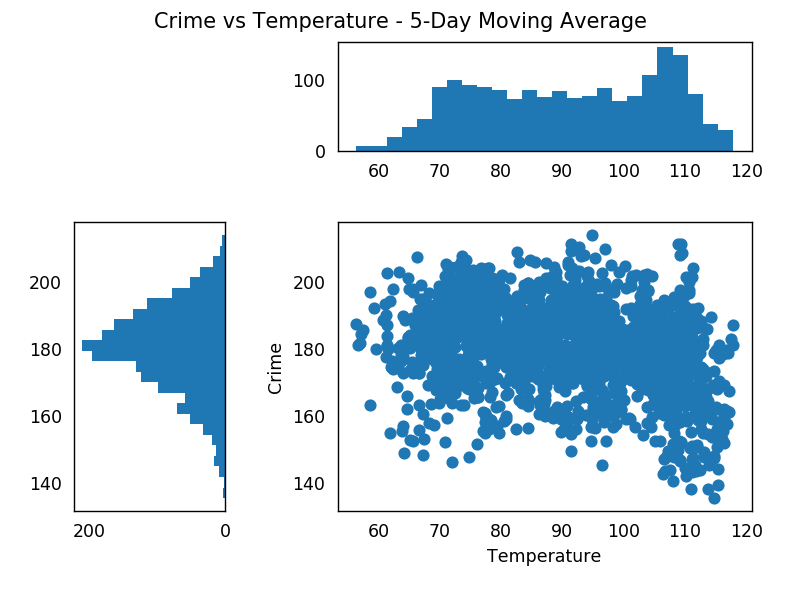

In [120]:
# fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,6))

# ax1.scatter(crime_weather_df['Max_Temp'].values,crime_weather_df['Crime_Count'].values)
# ax2.hist(crime_weather_df['Crime_Count'],bins=20)
# ax3.hist(crime_weather_df['Max_Temp'],bins=20)

# fig.suptitle('Crime and Temperature')
# plt.tight_layout(pad=5)
# ax1.set(xlabel='Max Temperature',ylabel='Crime/Day')
# ax1.set_title('Plot 1: Crime by Temperature',fontsize=10)
# ax2.set(xlabel='Crime/Day',ylabel='Count')
# ax2.set_title('Plot 2: Crime Distribution',fontsize=10)
# ax3.set(xlabel='Max Temperature',ylabel='Count')
# ax3.set_title('Plot 3: Temperature Distribution',fontsize=10)

import matplotlib.gridspec as gridspec

plt.figure()
plt.suptitle('Crime vs Temperature - 5-Day Moving Average')
gspec = gridspec.GridSpec(3,3)

temp_hist = plt.subplot(gspec[0,1:])
crime_hist = plt.subplot(gspec[1:,0])
temp_crime_scat = plt.subplot(gspec[1:,1:])

temp_crime_scat.set(xlabel='Temperature',ylabel='Crime')

plt.tight_layout(pad=2)

temp_crime_scat.scatter(crime_weather_df['5_Day_SMA_Max_Temp'].values,crime_weather_df['5_Day_SMA_Crime'].values)
temp_hist.hist(crime_weather_df['5_Day_SMA_Max_Temp'],bins=25)
crime_hist.hist(crime_weather_df['5_Day_SMA_Crime'],bins=25,orientation='horizontal')
crime_hist.invert_xaxis()

temp_hist.tick_params(top='off', bottom='off', left='off', right='off')
crime_hist.tick_params(top='off', bottom='off', left='off', right='off')
temp_crime_scat.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


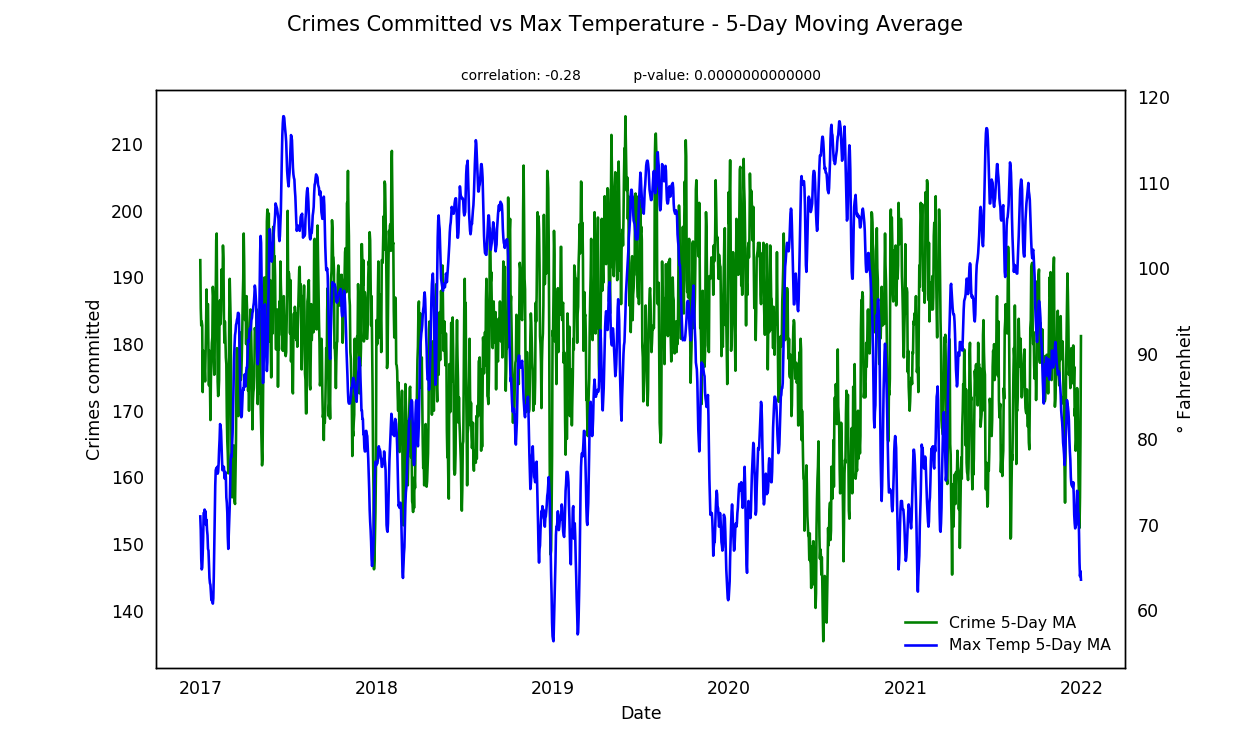

In [116]:
# 5_Day_SMA_Crime
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

# ax1.plot(crime_weather_df['Occurred_On_Date'],crime_weather_df['Crime_Count'],'g')
# ax2.plot(crime_weather_df['Occurred_On_Date'],crime_weather_df['Max_Temp'], 'b')
plot1 = ax1.plot(crime_weather_df['Occurred_On_Date'],crime_weather_df['5_Day_SMA_Crime'],'g')
plot2 = ax2.plot(crime_weather_df['Occurred_On_Date'],crime_weather_df['5_Day_SMA_Max_Temp'], 'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Crimes Committed vs Max Temperature - 5-Day Moving Average')
plt.title('correlation: {:.2f}            p-value: {:.13f}'.format(corr[0],corr[1]),fontdict={'fontsize': 8})
ax1.legend(plot1+plot2,['Crime 5-Day MA','Max Temp 5-Day MA'],loc=4,fontsize=9,frameon=False)
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


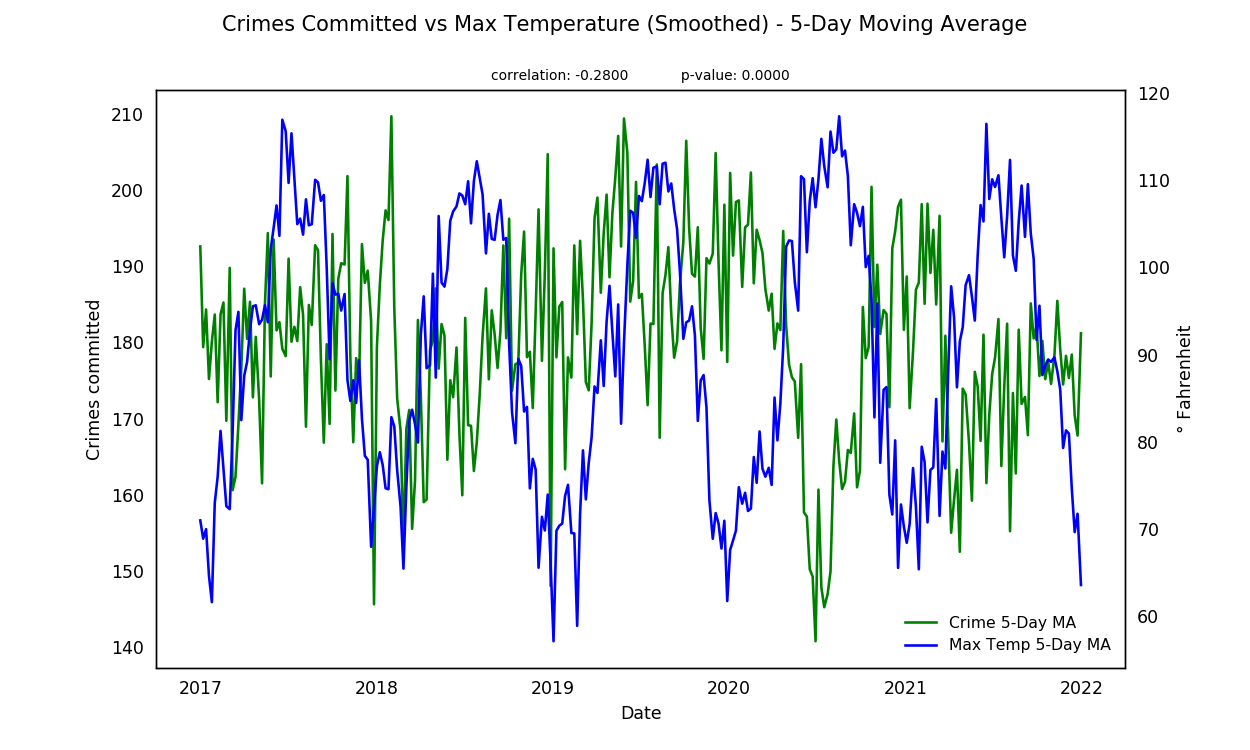

In [121]:
from scipy.interpolate import interp1d

x1=crime_weather_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=crime_weather_df['Crime_Count']
# y2=crime_weather_df['Max_Temp']
y1=crime_weather_df['5_Day_SMA_Crime']
y2=crime_weather_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

plot1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
plot2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Crimes Committed vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr[0],corr[1]),fontdict={'fontsize': 8})
ax1.legend(plot1+plot2,['Crime 5-Day MA','Max Temp 5-Day MA'],loc=4,fontsize=9,frameon=False)
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

In [88]:
crime_cat_weather_df = pd.merge(crime_cat_agg_df,weather_agg_df,how='inner',left_on='Occurred_On_Date',right_on='Date')
crime_cat_weather_df = crime_cat_weather_df.drop(['Date','Avg_Max_Temp','Avg_Min_Temp','Max_Temp_Delta','Min_Temp_Delta'], axis=1)
crime_cat_weather_df['Year'] = crime_cat_weather_df['Occurred_On_Date'].dt.year
crime_cat_weather_df['Month'] = crime_cat_weather_df['Occurred_On_Date'].dt.month
crime_cat_weather_df['Day'] = crime_cat_weather_df['Occurred_On_Date'].dt.day
crime_cat_weather_df['Days_In_Month'] = np.where((crime_cat_weather_df['Year'] == 2020) & (crime_cat_weather_df['Month'] == 2),crime_cat_weather_df['Occurred_On_Date'].dt.daysinmonth-1,crime_cat_weather_df['Occurred_On_Date'].dt.daysinmonth) 
crime_cat_weather_df['Day_Of_Year'] = np.where((crime_cat_weather_df['Year'] == 2020) & (crime_cat_weather_df['Occurred_On_Date'] > '2020-02-28'),crime_cat_weather_df['Occurred_On_Date'].dt.dayofyear - 1,crime_cat_weather_df['Occurred_On_Date'].dt.dayofyear)

agg_aslt_df = crime_cat_weather_df[crime_cat_weather_df['Uniform_Crime_Reporting_Category'] == 'AGGRAVATED ASSAULT'].reset_index().drop('index',axis=1)
arson_df = crime_cat_weather_df[crime_cat_weather_df['Uniform_Crime_Reporting_Category'] == 'ARSON'].reset_index().drop('index',axis=1)
burg_df = crime_cat_weather_df[crime_cat_weather_df['Uniform_Crime_Reporting_Category'] == 'BURGLARY'].reset_index().drop('index',axis=1)
drug_df = crime_cat_weather_df[crime_cat_weather_df['Uniform_Crime_Reporting_Category'] == 'DRUG OFFENSE'].reset_index().drop('index',axis=1)
lar_thft_df = crime_cat_weather_df[crime_cat_weather_df['Uniform_Crime_Reporting_Category'] == 'LARCENY-THEFT'].reset_index().drop('index',axis=1)
mv_thft_df = crime_cat_weather_df[crime_cat_weather_df['Uniform_Crime_Reporting_Category'] == 'MOTOR VEHICLE THEFT'].reset_index().drop('index',axis=1)
mrd_mns_df = crime_cat_weather_df[crime_cat_weather_df['Uniform_Crime_Reporting_Category'] == 'MURDER AND NON-NEGLIGENT MANSLAUGHTER'].reset_index().drop('index',axis=1)
rape_df = crime_cat_weather_df[crime_cat_weather_df['Uniform_Crime_Reporting_Category'] == 'RAPE'].reset_index().drop('index',axis=1)
rob_df = crime_cat_weather_df[crime_cat_weather_df['Uniform_Crime_Reporting_Category'] == 'ROBBERY'].reset_index().drop('index',axis=1)

# corr_agg_aslt = stats.pearsonr(agg_aslt_df['Crime_Count'],agg_aslt_df['Max_Temp'])
# corr_arson = stats.pearsonr(arson_df['Crime_Count'],arson_df['Max_Temp'])
# corr_burg = stats.pearsonr(burg_df['Crime_Count'],burg_df['Max_Temp'])
# corr_drug = stats.pearsonr(drug_df['Crime_Count'],drug_df['Max_Temp'])
# corr_lar_thft = stats.pearsonr(lar_thft_df['Crime_Count'],lar_thft_df['Max_Temp'])
# corr_mv_thft = stats.pearsonr(mv_thft_df['Crime_Count'],mv_thft_df['Max_Temp'])
# corr_mrd_mns = stats.pearsonr(mrd_mns_df['Crime_Count'],mrd_mns_df['Max_Temp'])
# corr_rape = stats.pearsonr(rape_df['Crime_Count'],rape_df['Max_Temp'])
# corr_rob = stats.pearsonr(rob_df['Crime_Count'],rob_df['Max_Temp'])

corr_agg_aslt = stats.pearsonr(agg_aslt_df['5_Day_SMA_Crime'],agg_aslt_df['5_Day_SMA_Max_Temp'])
corr_arson = stats.pearsonr(arson_df['5_Day_SMA_Crime'],arson_df['5_Day_SMA_Max_Temp'])
corr_burg = stats.pearsonr(burg_df['5_Day_SMA_Crime'],burg_df['5_Day_SMA_Max_Temp'])
corr_drug = stats.pearsonr(drug_df['5_Day_SMA_Crime'],drug_df['5_Day_SMA_Max_Temp'])
corr_lar_thft = stats.pearsonr(lar_thft_df['5_Day_SMA_Crime'],lar_thft_df['5_Day_SMA_Max_Temp'])
corr_mv_thft = stats.pearsonr(mv_thft_df['5_Day_SMA_Crime'],mv_thft_df['5_Day_SMA_Max_Temp'])
corr_mrd_mns = stats.pearsonr(mrd_mns_df['5_Day_SMA_Crime'],mrd_mns_df['5_Day_SMA_Max_Temp'])
corr_rape = stats.pearsonr(rape_df['5_Day_SMA_Crime'],rape_df['5_Day_SMA_Max_Temp'])
corr_rob = stats.pearsonr(rob_df['5_Day_SMA_Crime'],rob_df['5_Day_SMA_Max_Temp'])

agg_aslt_df
# arson_df
# burg_df
# drug_df
# lar_thft_df
# mv_thft_df
# mrd_mns_df
# rape_df
# rob_df

Occurred_On_Date Uniform_Crime_Reporting_Category  Crime_Count  \
0          2017-01-01               AGGRAVATED ASSAULT           24   
1          2017-01-02               AGGRAVATED ASSAULT           11   
2          2017-01-03               AGGRAVATED ASSAULT            6   
3          2017-01-04               AGGRAVATED ASSAULT            7   
4          2017-01-05               AGGRAVATED ASSAULT            7   
5          2017-01-06               AGGRAVATED ASSAULT            9   
6          2017-01-07               AGGRAVATED ASSAULT           11   
7          2017-01-08               AGGRAVATED ASSAULT           13   
8          2017-01-09               AGGRAVATED ASSAULT           10   
9          2017-01-10               AGGRAVATED ASSAULT            9   
10         2017-01-11               AGGRAVATED ASSAULT            8   
11         2017-01-12               AGGRAVATED ASSAULT           15   
12         2017-01-13               AGGRAVATED ASSAULT           12   
13         2017-01-14               AGGRAVATED ASSAULT           16   
14         2017-01-15               AGGRAVATED ASSAULT           11   
15         2017-01-16               AGGRAVATED ASSAULT           11   
16         2017-01-17               AGGRAVATED ASSAULT           14   
17         2017-01-18               AGGRAVATED ASSAULT            8   
18         2017-01-19               AGGRAVATED ASSAULT           14   
19         2017-01-20               AGGRAVATED ASSAULT           12   
20         2017-01-21               AGGRAVATED ASSAULT           14   
21         2017-01-22               AGGRAVATED ASSAULT           22   
22         2017-01-23               AGGRAVATED ASSAULT           15   
23         2017-01-24               AGGRAVATED ASSAULT           11   
24         2017-01-25               AGGRAVATED ASSAULT            8   
25         2017-01-26               AGGRAVATED ASSAULT            9   
26         2017-01-27               AGGRAVATED ASSAULT            2   
27         2017-01-28               AGGRAVATED ASSAULT           11   
28         2017-01-29               AGGRAVATED ASSAULT           10   
29         2017-01-30               AGGRAVATED ASSAULT            6   
...               ...                              ...          ...   
1795       2021-12-02               AGGRAVATED ASSAULT           18   
1796       2021-12-03               AGGRAVATED ASSAULT           14   
1797       2021-12-04               AGGRAVATED ASSAULT           20   
1798       2021-12-05               AGGRAVATED ASSAULT           16   
1799       2021-12-06               AGGRAVATED ASSAULT           14   
1800       2021-12-07               AGGRAVATED ASSAULT           16   
1801       2021-12-08               AGGRAVATED ASSAULT           11   
1802       2021-12-09               AGGRAVATED ASSAULT           21   
1803       2021-12-10               AGGRAVATED ASSAULT           14   
1804       2021-12-11               AGGRAVATED ASSAULT           18   
1805       2021-12-12               AGGRAVATED ASSAULT           20   
1806       2021-12-13               AGGRAVATED ASSAULT           17   
1807       2021-12-14               AGGRAVATED ASSAULT           10   
1808       2021-12-15               AGGRAVATED ASSAULT           16   
1809       2021-12-16               AGGRAVATED ASSAULT            7   
1810       2021-12-17               AGGRAVATED ASSAULT           17   
1811       2021-12-18               AGGRAVATED ASSAULT           14   
1812       2021-12-19               AGGRAVATED ASSAULT           15   
1813       2021-12-20               AGGRAVATED ASSAULT           19   
1814       2021-12-21               AGGRAVATED ASSAULT           14   
1815       2021-12-22               AGGRAVATED ASSAULT           13   
1816       2021-12-23               AGGRAVATED ASSAULT           18   
1817       2021-12-24               AGGRAVATED ASSAULT            8   
1818       2021-12-25               AGGRAVATED ASSAULT           17   
1819       2021-12-26        

In [89]:
total_crime = crime_cat_weather_df['Crime_Count'].sum()
total_crime_by_cat = crime_cat_weather_df.groupby(['Uniform_Crime_Reporting_Category'])['Crime_Count'].sum().reset_index()

total_crime
total_crime_by_cat['Crime_Percent'] = round(total_crime_by_cat['Crime_Count']/total_crime,4)*100
total_crime_by_cat.sort_values(by='Crime_Percent',ascending=False).reset_index(drop=True)

Uniform_Crime_Reporting_Category  Crime_Count  Crime_Percent
0                          LARCENY-THEFT       169695          51.66
1                               BURGLARY        42373          12.90
2                    MOTOR VEHICLE THEFT        35148          10.70
3                           DRUG OFFENSE        29907           9.10
4                     AGGRAVATED ASSAULT        29170           8.88
5                                ROBBERY        13534           4.12
6                                   RAPE         4981           1.52
7                                  ARSON         2907           0.88
8  MURDER AND NON-NEGLIGENT MANSLAUGHTER          778           0.24

<IPython.core.display.Javascript object>


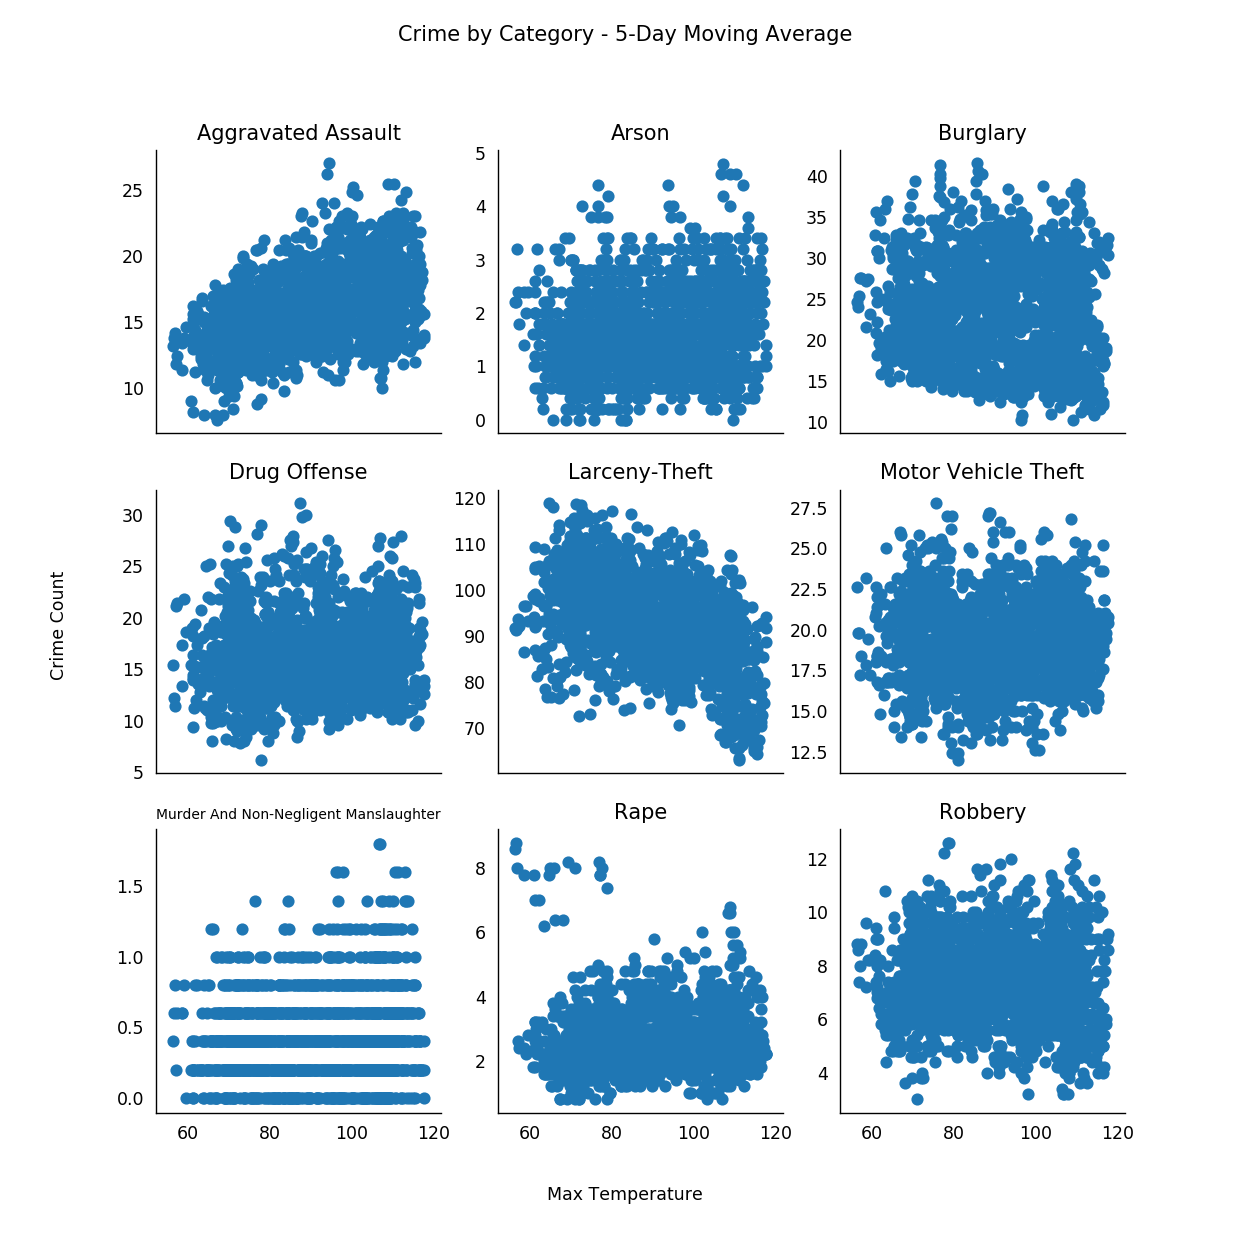

In [122]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(10,10),sharex=True)

subplots = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
dfs = [agg_aslt_df,arson_df,burg_df,drug_df,lar_thft_df,mv_thft_df,mrd_mns_df,rape_df,rob_df]
titles = ['Aggravated Assault','Arson','Burglary','Drug Offense','Larceny-Theft','Motor Vehicle Theft','Murder And Non-Negligent Manslaughter','Rape','Robbery']

# for subplot,df,title in zip(subplots,dfs,titles):
#     subplot.scatter(df['Max_Temp'].values,df['Crime_Count'].values)
#     if subplot != ax7:
#         subplot.set_title(title)
#     else:
#         subplot.set_title(title,fontsize=8)
#     subplot.spines['right'].set_visible(False)
#     subplot.spines['top'].set_visible(False)

for subplot,df,title in zip(subplots,dfs,titles):
    subplot.scatter(df['5_Day_SMA_Max_Temp'].values,df['5_Day_SMA_Crime'].values)
    if subplot != ax7:
        subplot.set_title(title)
    else:
        subplot.set_title(title,fontsize=8)
    subplot.spines['right'].set_visible(False)
    subplot.spines['top'].set_visible(False)
    subplot.tick_params(top='off', bottom='off', left='off', right='off')

fig.suptitle('Crime by Category - 5-Day Moving Average')
fig.text(0.5, 0.04, 'Max Temperature', ha='center')
fig.text(0.04, 0.5, 'Crime Count', va='center', rotation='vertical')

plt.show()

<IPython.core.display.Javascript object>


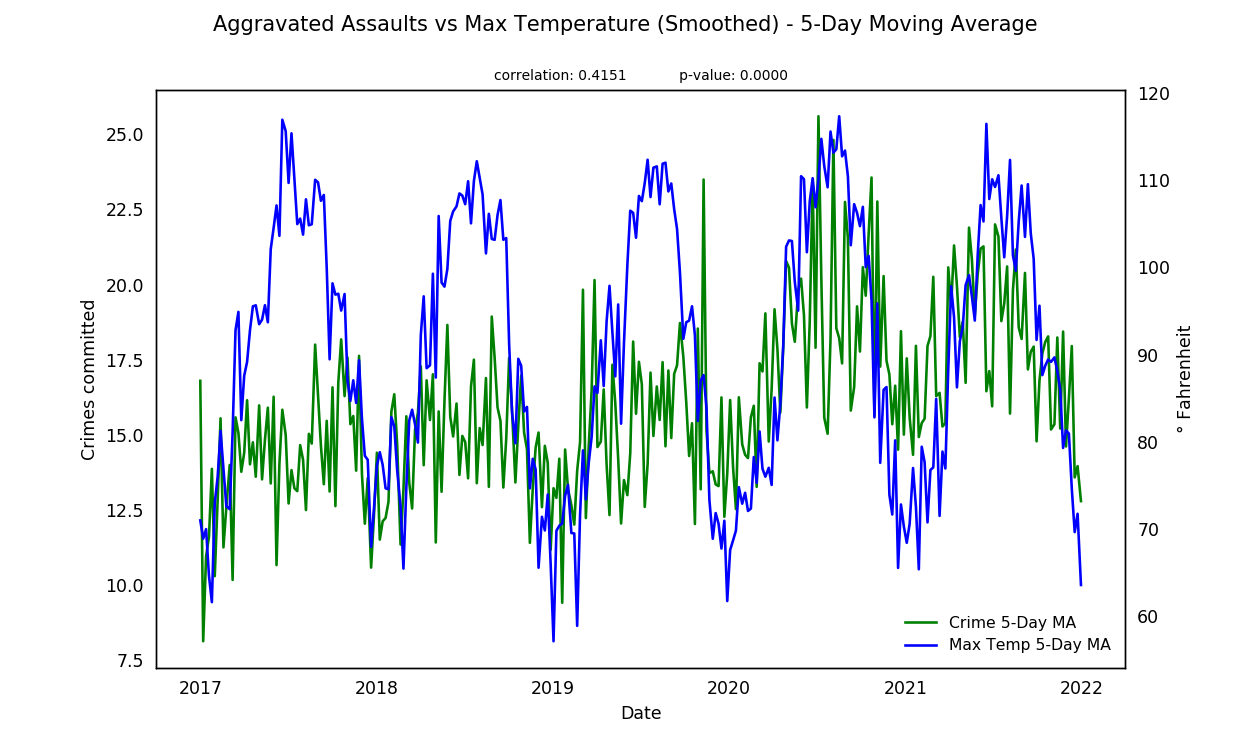

In [123]:
x1=agg_aslt_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=agg_aslt_df['Crime_Count']
# y2=agg_aslt_df['Max_Temp']
y1=agg_aslt_df['5_Day_SMA_Crime']
y2=agg_aslt_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

plot1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
plot2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Aggravated Assaults vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr_agg_aslt[0],corr_agg_aslt[1]),fontdict={'fontsize': 8})
ax1.legend(plot1+plot2,['Crime 5-Day MA','Max Temp 5-Day MA'],loc=4,fontsize=9,frameon=False)
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


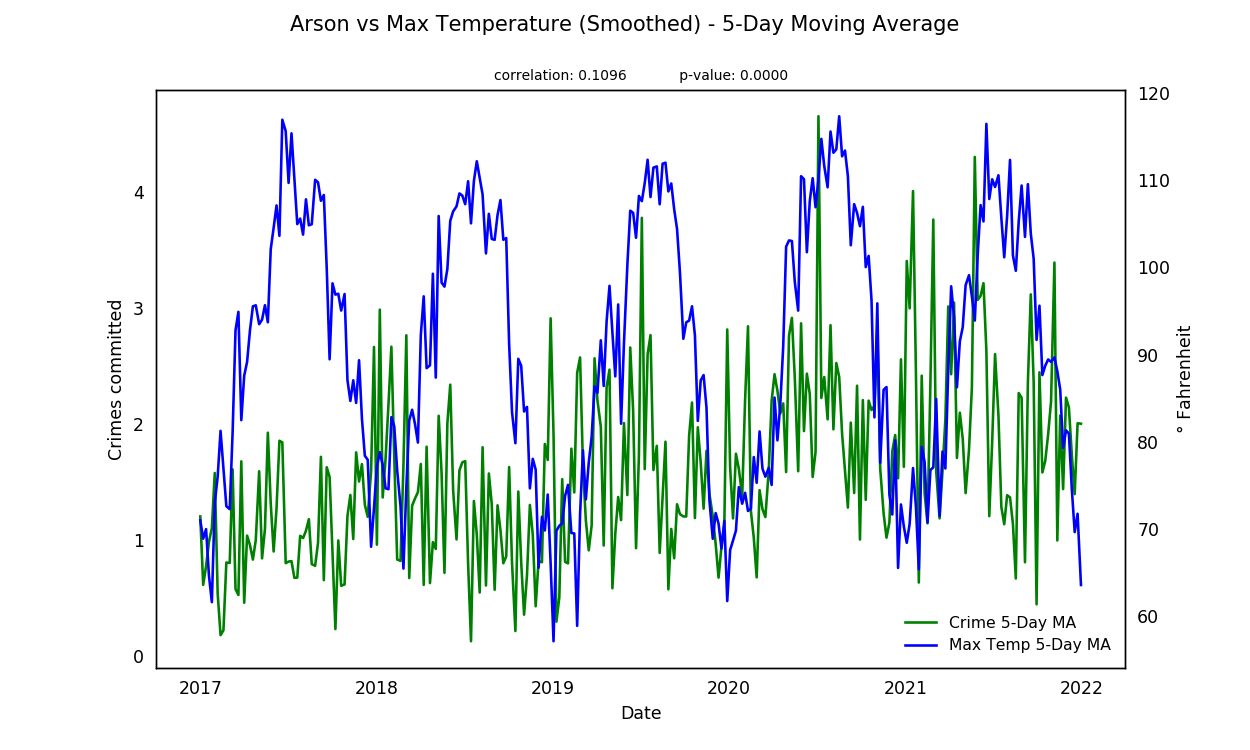

In [124]:
x1=arson_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=arson_df['Crime_Count']
# y2=arson_df['Max_Temp']
y1=arson_df['5_Day_SMA_Crime']
y2=arson_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

plot1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
plot2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Arson vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr_arson[0],corr_arson[1]),fontdict={'fontsize': 8})
ax1.legend(plot1+plot2,['Crime 5-Day MA','Max Temp 5-Day MA'],loc=4,fontsize=9,frameon=False)
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


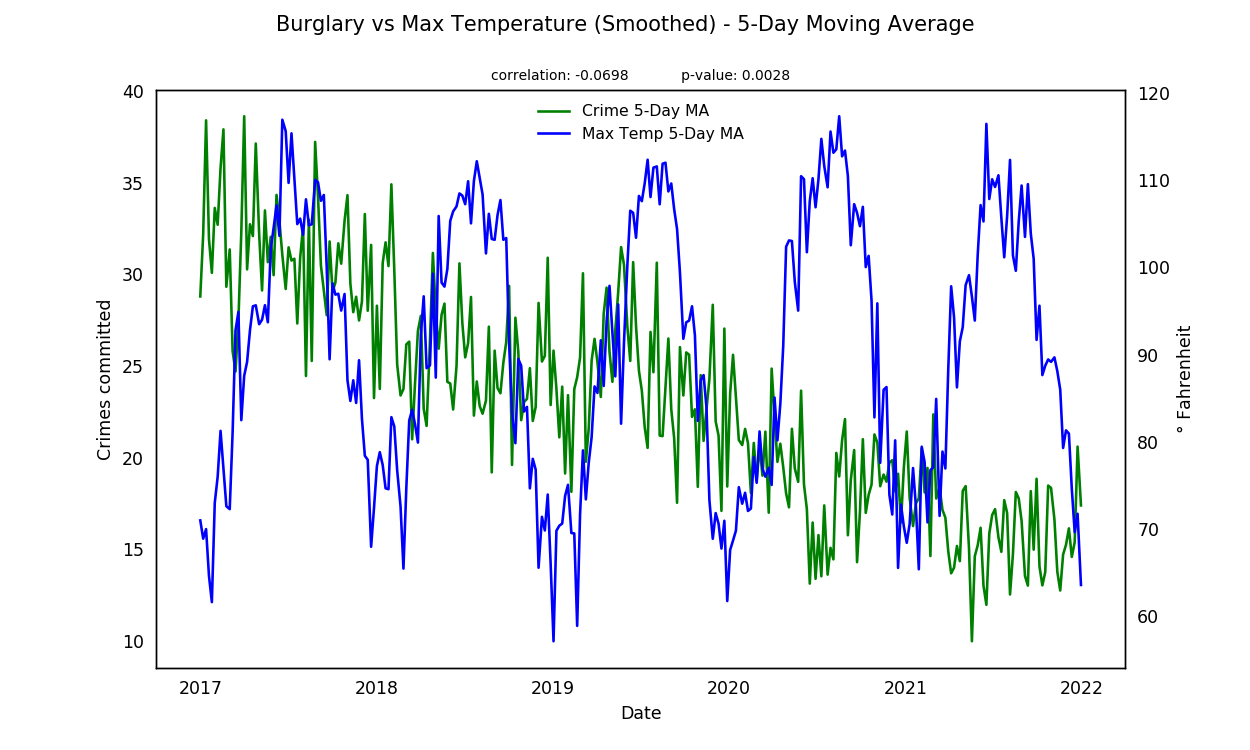

In [125]:
x1=burg_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=burg_df['Crime_Count']
# y2=burg_df['Max_Temp']
y1=burg_df['5_Day_SMA_Crime']
y2=burg_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

plot1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
plot2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Burglary vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr_burg[0],corr_burg[1]),fontdict={'fontsize': 8})
ax1.legend(plot1+plot2,['Crime 5-Day MA','Max Temp 5-Day MA'],loc=9,fontsize=9,frameon=False)
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


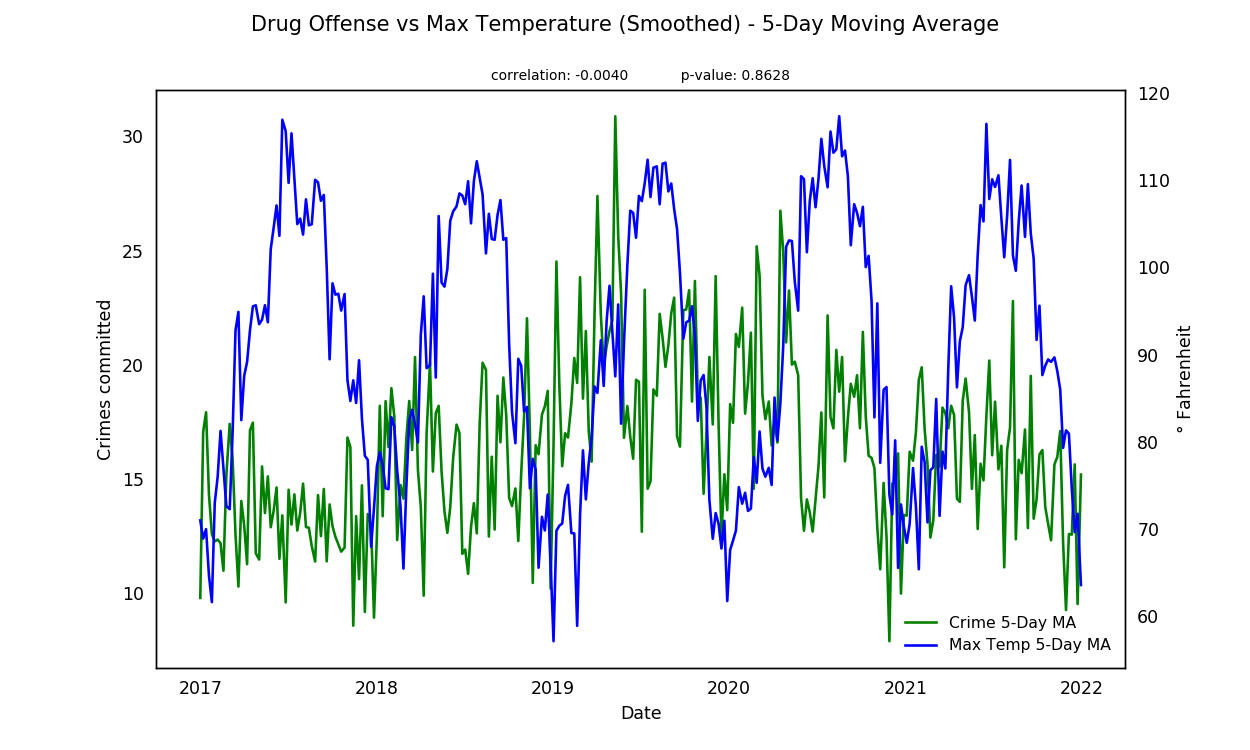

In [126]:
x1=drug_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=drug_df['Crime_Count']
# y2=drug_df['Max_Temp']
y1=drug_df['5_Day_SMA_Crime']
y2=drug_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

plot1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
plot2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Drug Offense vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr_drug[0],corr_drug[1]),fontdict={'fontsize': 8})
ax1.legend(plot1+plot2,['Crime 5-Day MA','Max Temp 5-Day MA'],loc=4,fontsize=9,frameon=False)
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


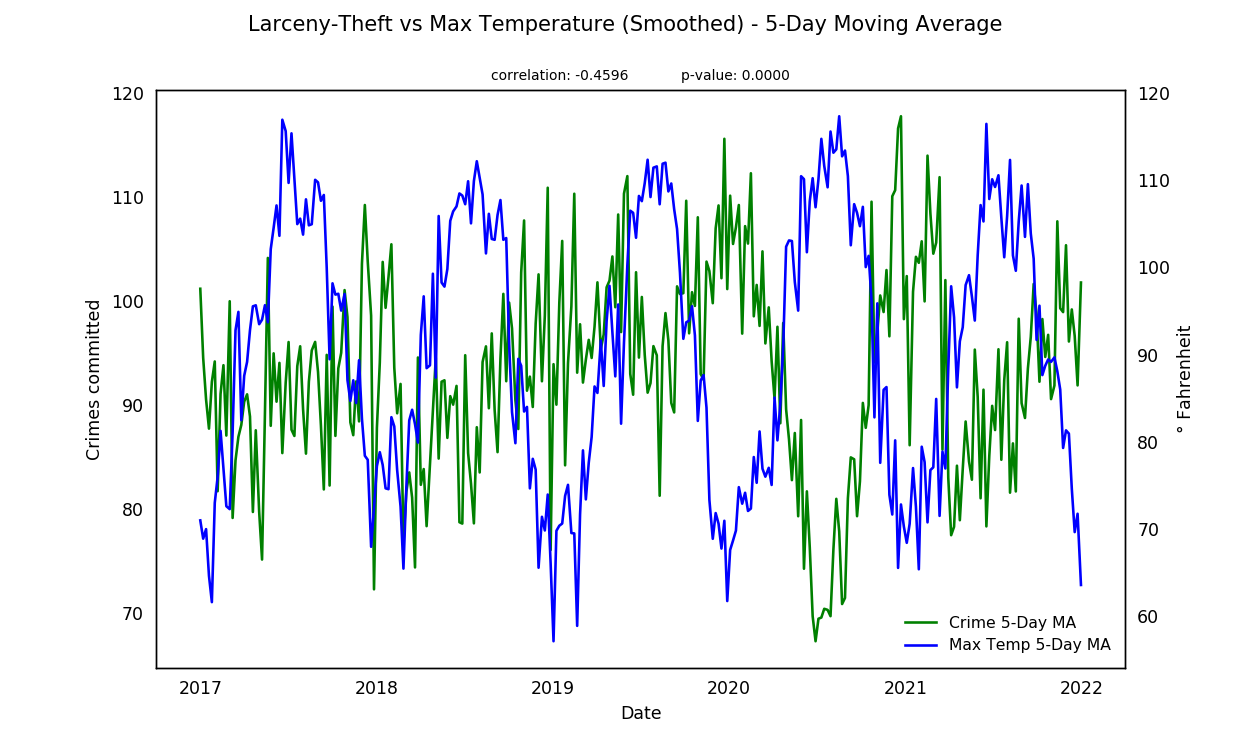

In [127]:
x1=lar_thft_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=lar_thft_df['Crime_Count']
# y2=lar_thft_df['Max_Temp']
y1=lar_thft_df['5_Day_SMA_Crime']
y2=lar_thft_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

plot1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
plot2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Larceny-Theft vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr_lar_thft[0],corr_lar_thft[1]),fontdict={'fontsize': 8})
ax1.legend(plot1+plot2,['Crime 5-Day MA','Max Temp 5-Day MA'],loc=4,fontsize=9,frameon=False)
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


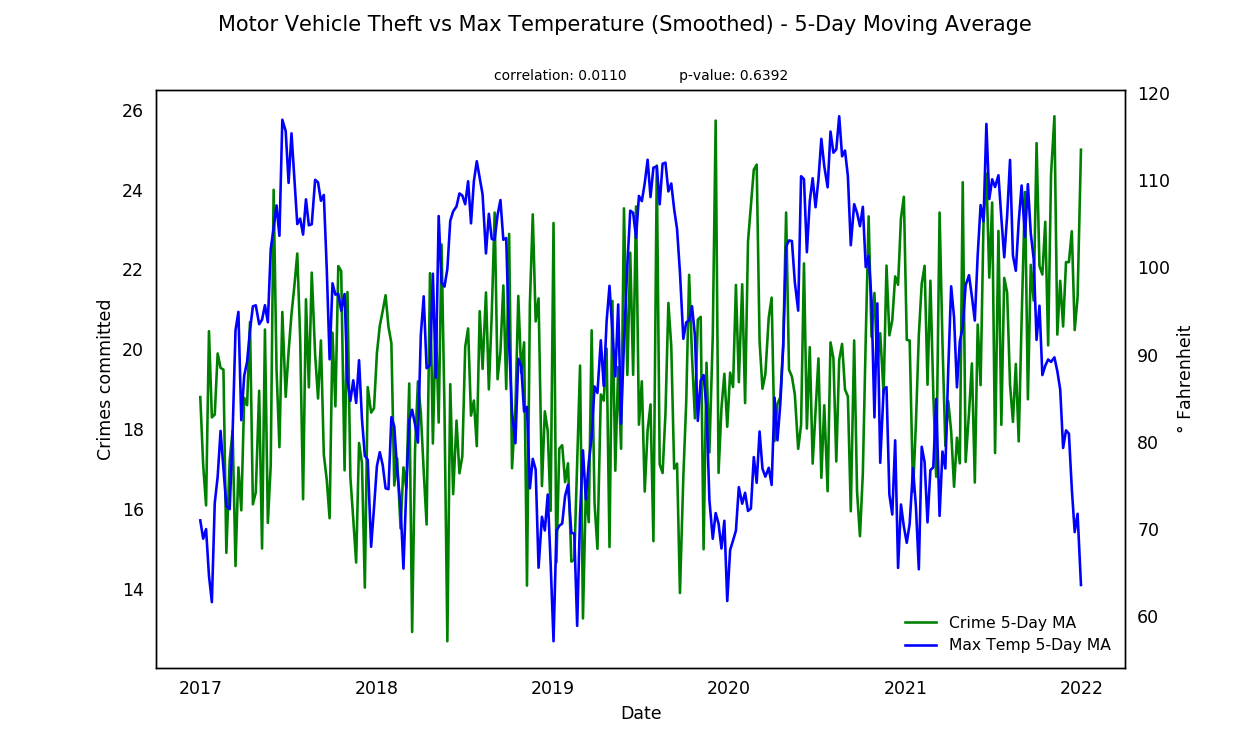

In [128]:
x1=mv_thft_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=mv_thft_df['Crime_Count']
# y2=mv_thft_df['Max_Temp']
y1=mv_thft_df['5_Day_SMA_Crime']
y2=mv_thft_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

plot1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
plot2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Motor Vehicle Theft vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr_mv_thft[0],corr_mv_thft[1]),fontdict={'fontsize': 8})
ax1.legend(plot1+plot2,['Crime 5-Day MA','Max Temp 5-Day MA'],loc=4,fontsize=9,frameon=False)
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


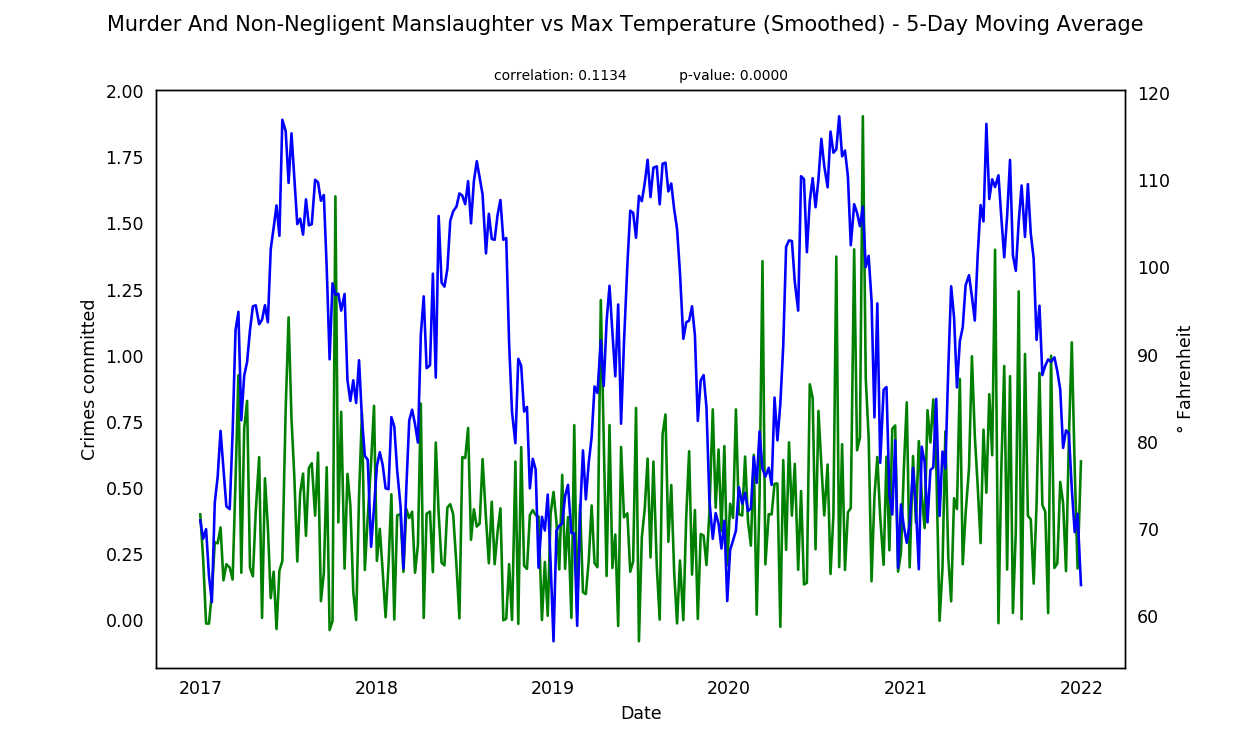

In [129]:
x1=mrd_mns_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=mrd_mns_df['Crime_Count']
# y2=mrd_mns_df['Max_Temp']
y1=mrd_mns_df['5_Day_SMA_Crime']
y2=mrd_mns_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

line1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
line2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Murder And Non-Negligent Manslaughter vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr_mrd_mns[0],corr_mrd_mns[1]),fontdict={'fontsize': 8})
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


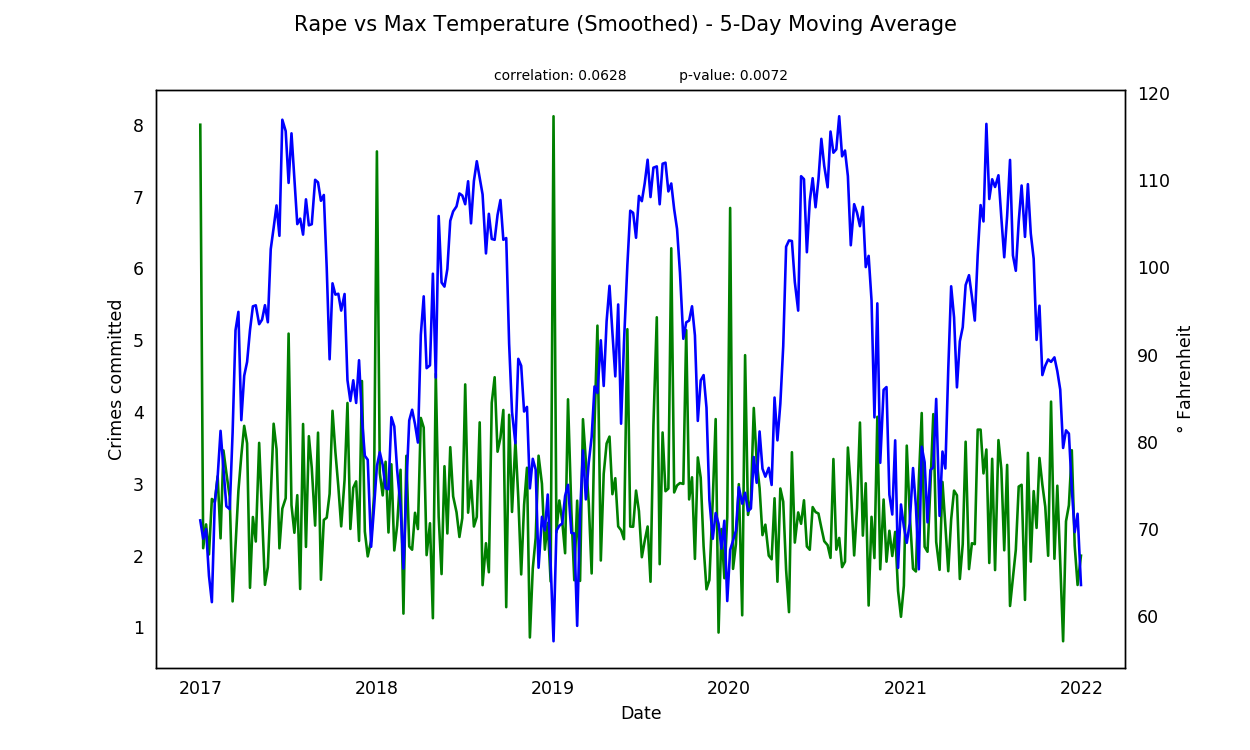

In [130]:
x1=rape_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=rape_df['Crime_Count']
# y2=rape_df['Max_Temp']
y1=rape_df['5_Day_SMA_Crime']
y2=rape_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

line1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
line2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Rape vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr_rape[0],corr_rape[1]),fontdict={'fontsize': 8})
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

<IPython.core.display.Javascript object>


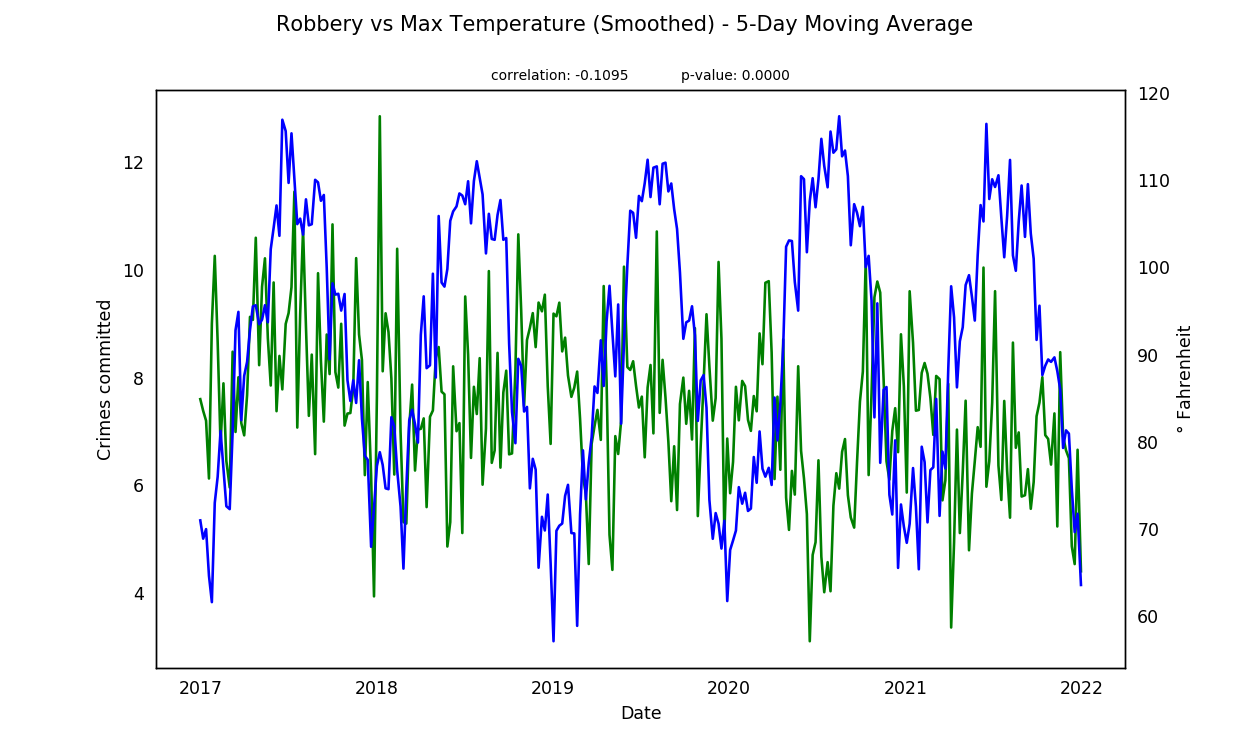

In [131]:
x1=rob_df['Occurred_On_Date'].apply(mpl_dates.date2num)
# y1=rob_df['Crime_Count']
# y2=rob_df['Max_Temp']
y1=rob_df['5_Day_SMA_Crime']
y2=rob_df['5_Day_SMA_Max_Temp']

crime_inter = interp1d(x1,y1,kind='cubic')
temp_inter = interp1d(x1,y2,kind='cubic')

x1_=np.linspace(x1.min(),x1.max(),300)
y1_=crime_inter(x1_)
y2_=temp_inter(x1_)

# fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))
fig, ax1 = plt.subplots(figsize=(10,6))

ax2 = ax1.twinx()

line1 = ax1.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y1_,'g')
line2 = ax2.plot((pd.Series(x1_)).astype(int).map(pd.Timestamp.fromordinal),y2_,'b')

ax1.set_ylabel('Crimes committed')
ax1.set_xlabel('Date')
ax2.set_ylabel('° Fahrenheit')
fig.suptitle('Robbery vs Max Temperature (Smoothed) - 5-Day Moving Average')
plt.title('correlation: {:.4f}            p-value: {:.4f}'.format(corr_rob[0],corr_rob[1]),fontdict={'fontsize': 8})
ax1.tick_params(top='off', bottom='off', left='off', right='off')
ax2.tick_params(top='off', bottom='off', left='off', right='off')

plt.show()

## 5 Discussion

###### You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.
    
    The visualizations presented here were concerned with answering the question of how does temperature in Phoenix, AZ affect crime. Crime data was sourced from the City of Phoenix's "City of Phoenix Open Data" website and includes data from 2017-2021. Additionally, weather data was sourced from the National Centers for Environmental Information website using daily summaries for the City of Phoenix between 2017-2021 as querying parameters. Any leap years in the data have been dropped from analysis to provide a more consistent comparison between years. A 5-day moving average was plotted for each crime and max temperature to help identify any trends in the data.
 
    The main plot of the analysis ("Crimes Committed vs Max Temperature (Smoothed) – 5-Day Moving Average") indicates that there is a minimal negative relationship between total crimes committed and temperature (-.28 correlation). This would imply that as temperatures cool off, crime increased in Phoenix from 2017-2021. This contrasts with the initial hypothesis that crime would increase as temperature would increase. However, I believe this to be skewed by specific categories of crime that accounted for most crimes committed over that timeframe, specifically, larceny-theft (51.66% of crimes 2017-2021). Because of this I broke out each category of crime separately to see what effects temperature had on their rates. For the most part, many crime categories had a very minimal relationship between crime and temperature (+/- .12 correlation). There were two crimes specifically that stood out than the others because they had more distinguished relationship between crime and temperature - aggravated assault & larceny-theft (.4151 & -.4596 correlation respectively). I believe that there might be outside circumstances playing a factor (negative or positive) into these relationships over this specific time - the COVID-19 pandemic. You can see a spike in aggravated assaults between the years 2020-2021 that wasn't seen previously. The fact that many people were shuttered indoors - potentially with abusive relatives or partners - could have led to this huge spike. On the other side, we saw a significant decrease in larceny-theft over the timeframe of the initial COVID-19 shutdowns that wasn't seen in the past. I think that this may have inflated the negative correlation with temperature. Overall, I would say that there needs to be further analysis done (over a longer timeframe potentially) to really get a better understanding if there is a concrete relationship between crime and temperature.
